# Homework 03: Learning Curves and Training Workflow

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

In this homework, you will use **early stopping** to select the "best" model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance. Test accuracy is reported for reference but is not used for model selection.

> **Note:** Throughout this homework, best always refers to the model selected by early stopping at the epoch of minimum validation loss. Do not report metrics from the final training epoch unless explicitly instructed.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [3]:
import ipykernel
ipykernel.__version__

'7.1.0'

In [5]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 42.3 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 51.1 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 46.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.5 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 20.7 MB/s  0:00:14m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 9.9 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 48.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 46.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 51.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 20.8 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


2026-02-01 15:36:48.408510: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-01 15:36:49.374018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-01 15:36:53.428338: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [7]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [8]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [9]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This data set is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [10]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [11]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [12]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

2026-02-01 15:38:32.820329: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [13]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



===== Activation: relu =====

Problem 1 - activation = relu



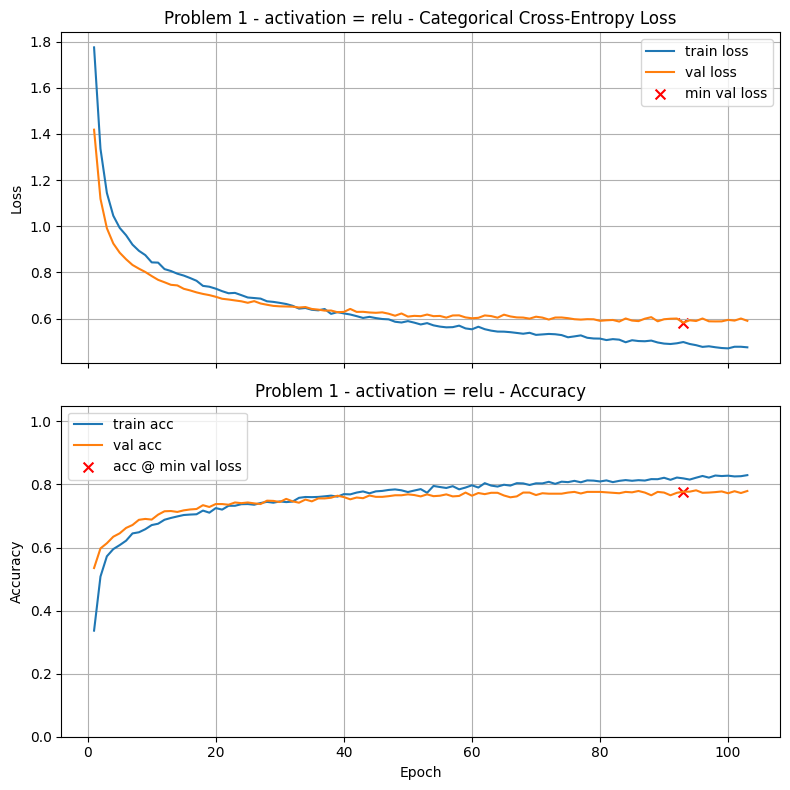

Final Training Loss:            0.4754
Final Training Accuracy:        0.8295
Final Validation Loss:          0.5902
Final Validation Accuracy:      0.7793
Minimum Validation Loss:        0.5823 (Epoch 93)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.6154
Test Accuracy: 0.7686

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:19
Best epoch (min val_loss): 92
Validation accuracy at best epoch: 0.7771

===== Activation: sigmoid =====

Problem 1 - activation = sigmoid



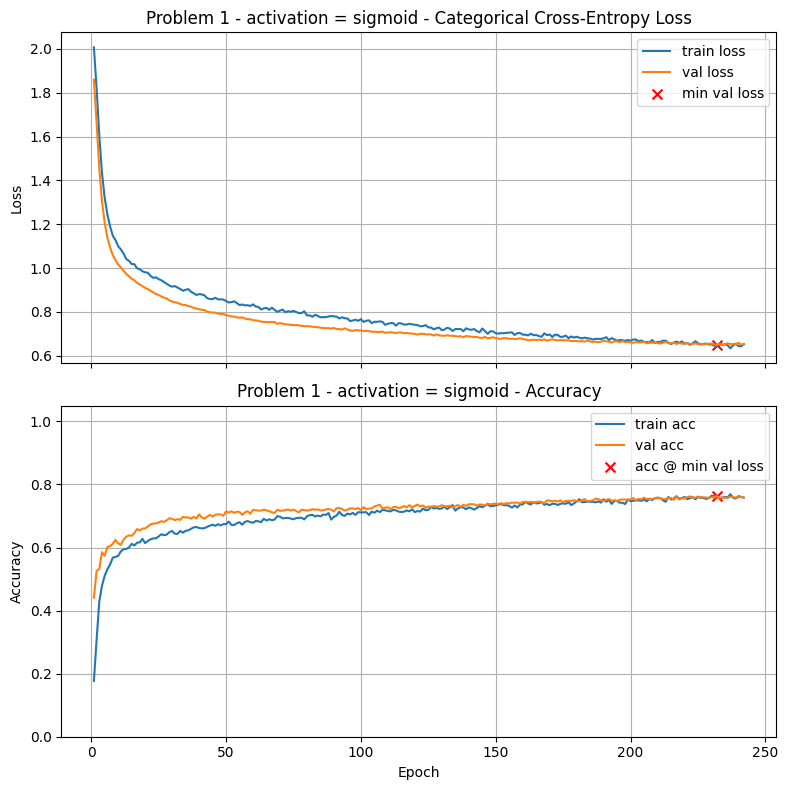

Final Training Loss:            0.6526
Final Training Accuracy:        0.7583
Final Validation Loss:          0.6517
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.6492 (Epoch 232)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6749
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:40
Best epoch (min val_loss): 231
Validation accuracy at best epoch: 0.7629

===== Activation: tanh =====

Problem 1 - activation = tanh



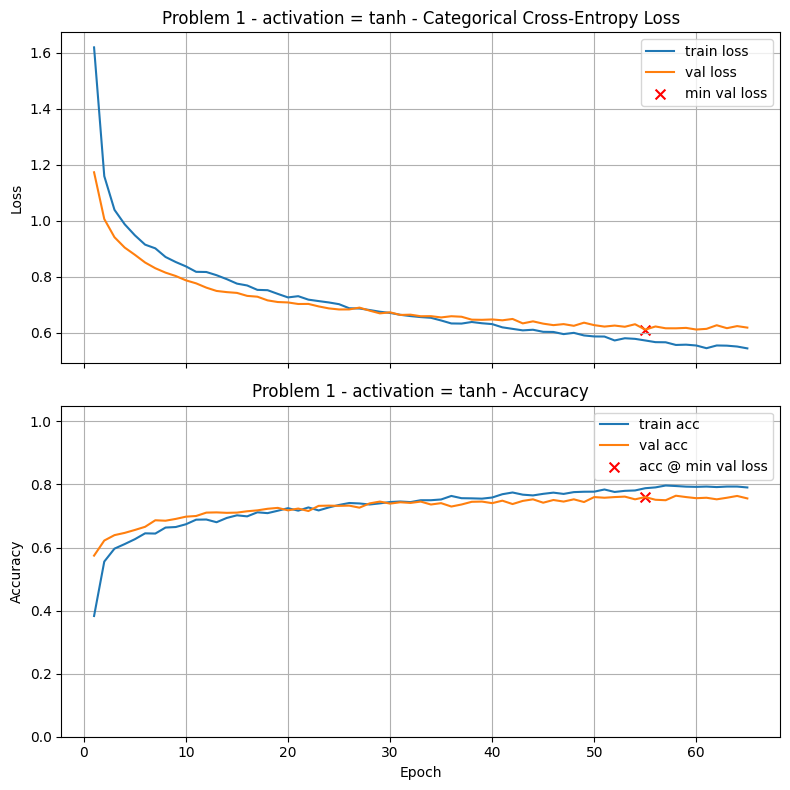

Final Training Loss:            0.5438
Final Training Accuracy:        0.7905
Final Validation Loss:          0.6180
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.6107 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6423
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:11
Best epoch (min val_loss): 54
Validation accuracy at best epoch: 0.7600

Best activation: relu
Best validation accuracy: 0.7771


In [18]:
# Your code here. Add as many cells as you need. 

# Problem 1: compare hidden-layer activations
activations = ["relu", "sigmoid", "tanh"]

results_val_acc = {}
results_best_epoch = {}
histories = {}

n_classes = len(np.unique(y_train))
n_inputs = X_train.shape[1]

for act in activations:
    print(f"\n===== Activation: {act} =====")

    # Baseline architecture from your notebook example:
    # (64, act, L2, dropout), (32, act, L2, dropout)
    # Using the same regularization/dropout values shown in the notebook:
    layer_list = [
        (64, act, 0.0,   0.0),
        (32, act, 0.001, 0.3)
    ]

    model = build_model(n_inputs, layer_list, n_classes)

    # IMPORTANT: your train_and_test only returns if return_history=True
    history = train_and_test(
        model,
        title=f"Problem 1 - activation = {act}",
        return_history=True,
        verbose=0
    )

    histories[act] = history

    # Early stopping selects the epoch of MIN validation loss
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])

    results_best_epoch[act] = best_epoch
    results_val_acc[act] = best_val_acc

    print(f"Best epoch (min val_loss): {best_epoch}")
    print(f"Validation accuracy at best epoch: {best_val_acc:.4f}")

# Pick best activation by validation accuracy at min val_loss epoch
best_act = max(results_val_acc, key=results_val_acc.get)
best_val = results_val_acc[best_act]

print("\n==============================")
print("Best activation:", best_act)
print(f"Best validation accuracy: {best_val:.4f}")
print("==============================")




### Graded Questions

In [19]:
activation_map = {
    "relu": 0,
    "sigmoid": 1,
    "tanh": 2
}


In [20]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = activation_map[best_act]            # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [21]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 0


In [22]:
# Set a1b to the validation accuracy found by this best activation function

a1b = best_val            # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7771


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



===== Learning rate: 0.001 =====

Problem 2 - lr = 0.001



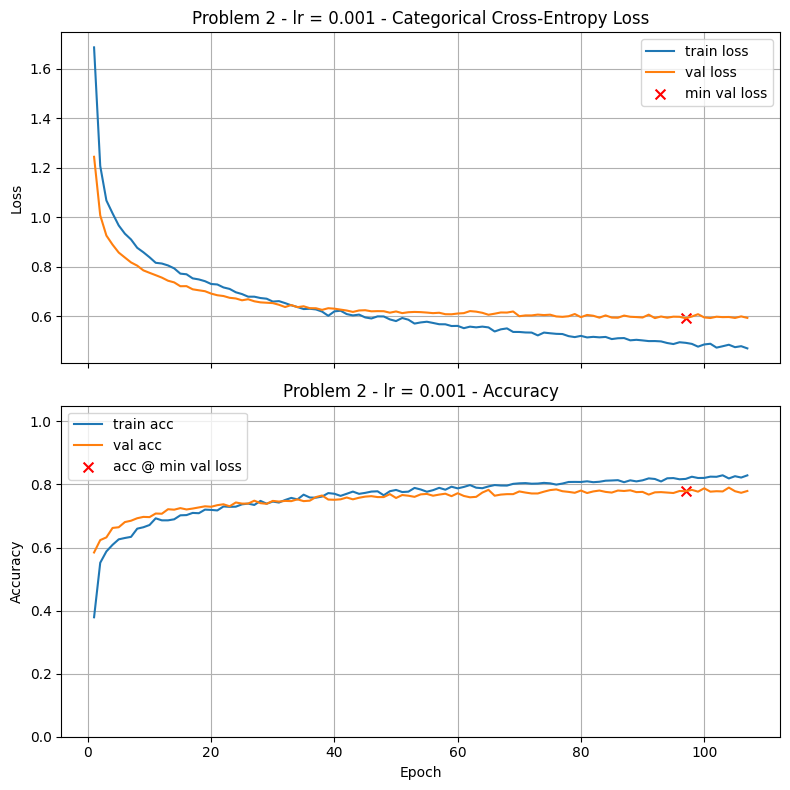

Final Training Loss:            0.4697
Final Training Accuracy:        0.8288
Final Validation Loss:          0.5930
Final Validation Accuracy:      0.7793
Minimum Validation Loss:        0.5917 (Epoch 97)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.6450
Test Accuracy: 0.7736

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:18
Best epoch (min val_loss): 96
Validation accuracy at best epoch: 0.7786

===== Learning rate: 0.0005 =====

Problem 2 - lr = 0.0005



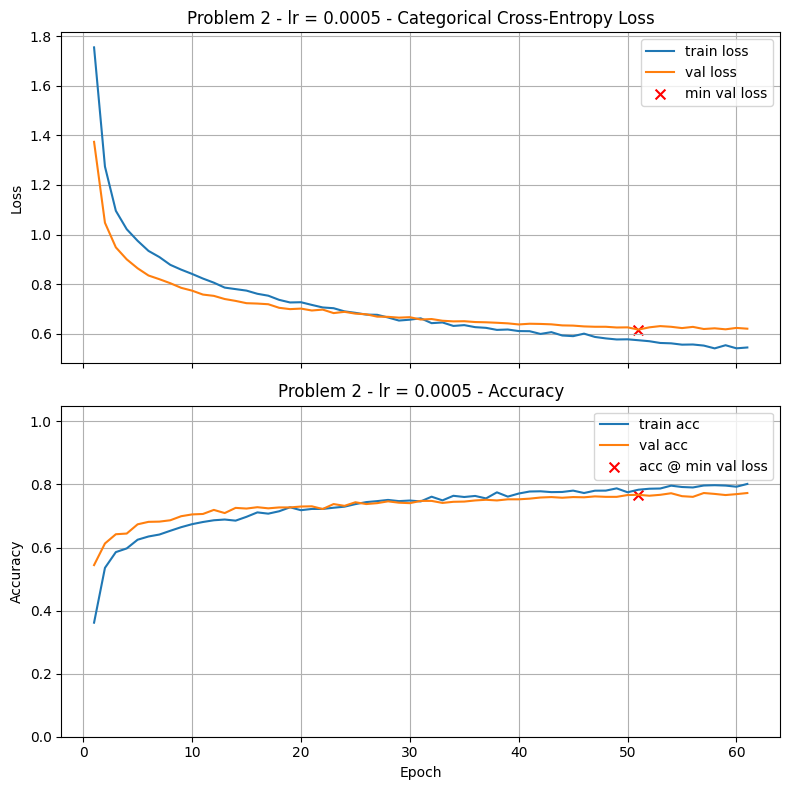

Final Training Loss:            0.5452
Final Training Accuracy:        0.8017
Final Validation Loss:          0.6209
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.6172 (Epoch 51)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6310
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:12
Best epoch (min val_loss): 50
Validation accuracy at best epoch: 0.7671

===== Learning rate: 0.0001 =====

Problem 2 - lr = 0.0001



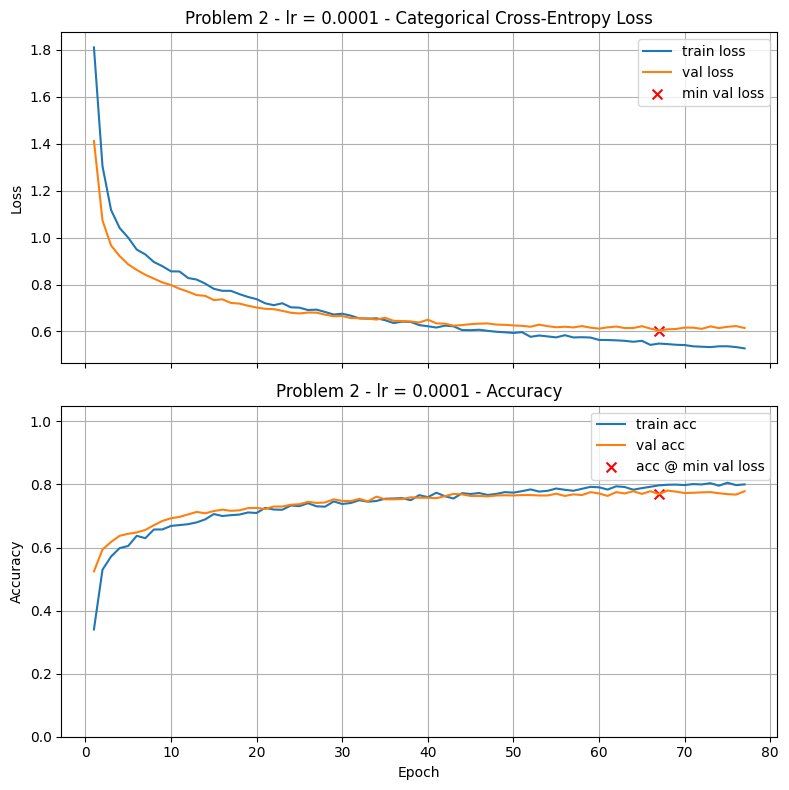

Final Training Loss:            0.5280
Final Training Accuracy:        0.8002
Final Validation Loss:          0.6147
Final Validation Accuracy:      0.7786
Minimum Validation Loss:        0.6041 (Epoch 67)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6398
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:13
Best epoch (min val_loss): 66
Validation accuracy at best epoch: 0.7693

===== Learning rate: 5e-05 =====

Problem 2 - lr = 5e-05



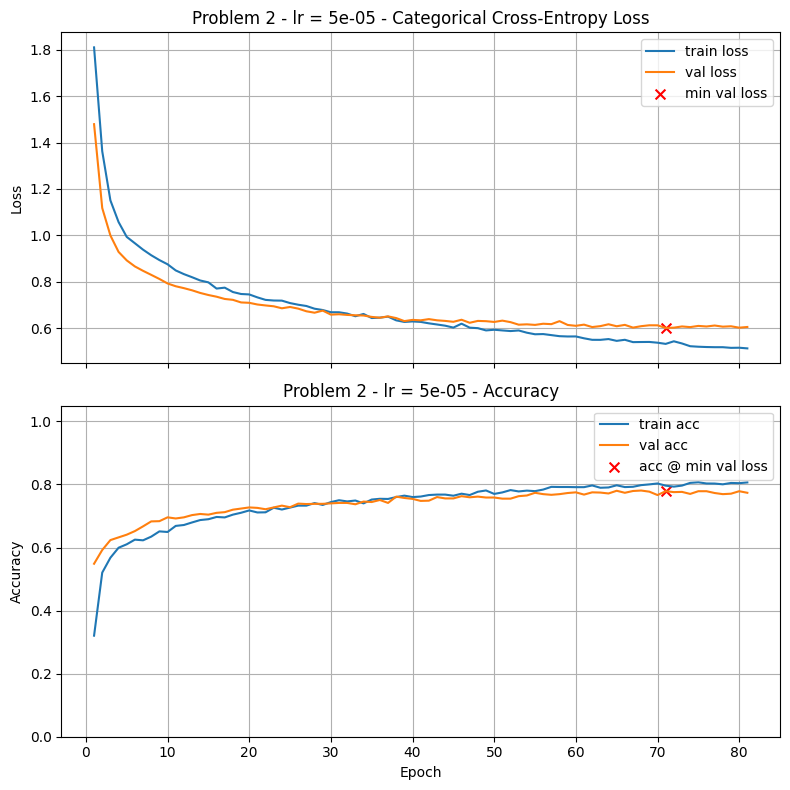

Final Training Loss:            0.5141
Final Training Accuracy:        0.8064
Final Validation Loss:          0.6062
Final Validation Accuracy:      0.7736
Minimum Validation Loss:        0.6022 (Epoch 71)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.6401
Test Accuracy: 0.7621

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:14
Best epoch (min val_loss): 70
Validation accuracy at best epoch: 0.7786

===== Learning rate: 1e-05 =====

Problem 2 - lr = 1e-05



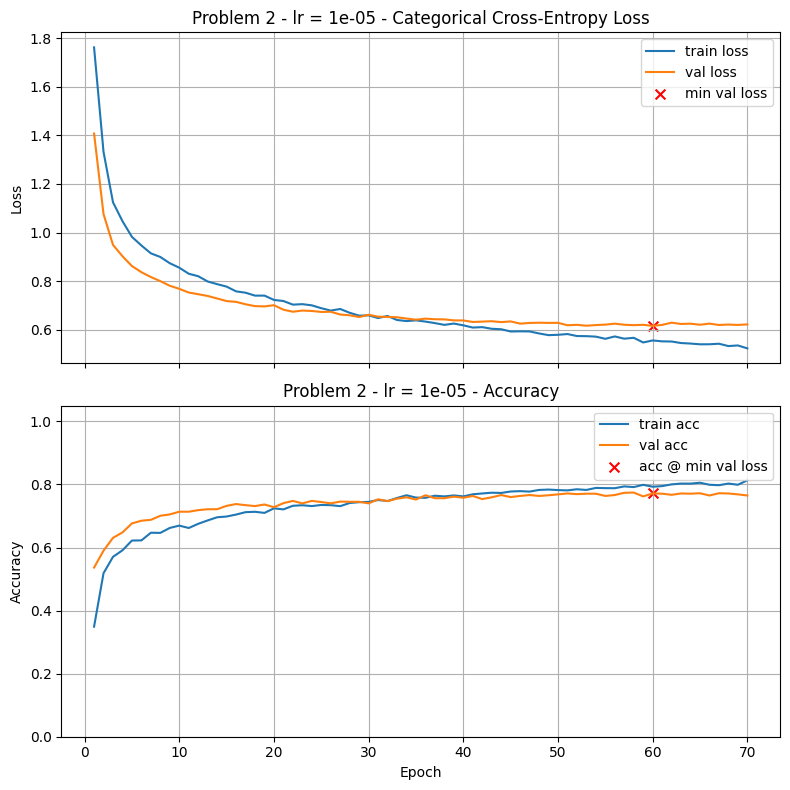

Final Training Loss:            0.5236
Final Training Accuracy:        0.8131
Final Validation Loss:          0.6222
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.6161 (Epoch 60)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6407
Test Accuracy: 0.7793

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:12
Best epoch (min val_loss): 59
Validation accuracy at best epoch: 0.7714

Best learning rate: 0.001
Best validation accuracy: 0.7786


In [26]:
# Your code here. Add as many cells as you need. 

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results_val_acc = {}
results_best_epoch = {}
histories = {}

best_activation = "relu"   # from Problem One
n_classes = len(np.unique(y_train))
n_inputs = X_train.shape[1]

for lr in learning_rates:
    print(f"\n===== Learning rate: {lr} =====")

    # Set learning rate used by build_model (global used internally)
    LEARNING_RATE = lr

    layer_list = [
        (64, best_activation, 0.0,   0.0),
        (32, best_activation, 0.001, 0.3)
    ]

    model = build_model(n_inputs, layer_list, n_classes)

    # 🚫 Do NOT pass learning_rate or max_epochs
    history = train_and_test(
        model,
        title=f"Problem 2 - lr = {lr}",
        return_history=True,
        verbose=0
    )

    histories[lr] = history

    # Early stopping: epoch of minimum validation loss
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])

    results_best_epoch[lr] = best_epoch
    results_val_acc[lr] = best_val_acc

    print(f"Best epoch (min val_loss): {best_epoch}")
    print(f"Validation accuracy at best epoch: {best_val_acc:.4f}")

# Identify best learning rate
best_lr = max(results_val_acc, key=results_val_acc.get)
best_val = results_val_acc[best_lr]

print("\n==============================")
print("Best learning rate:", best_lr)
print(f"Best validation accuracy: {best_val:.4f}")
print("==============================")


#### Graded Questions

In [27]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = best_lr           # Replace 0.0 with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.001000


In [29]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = best_val             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7786


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



===== Dropout (layer64=0.0, layer32=0.3) =====

Problem 3 - d1=0.0, d2=0.3



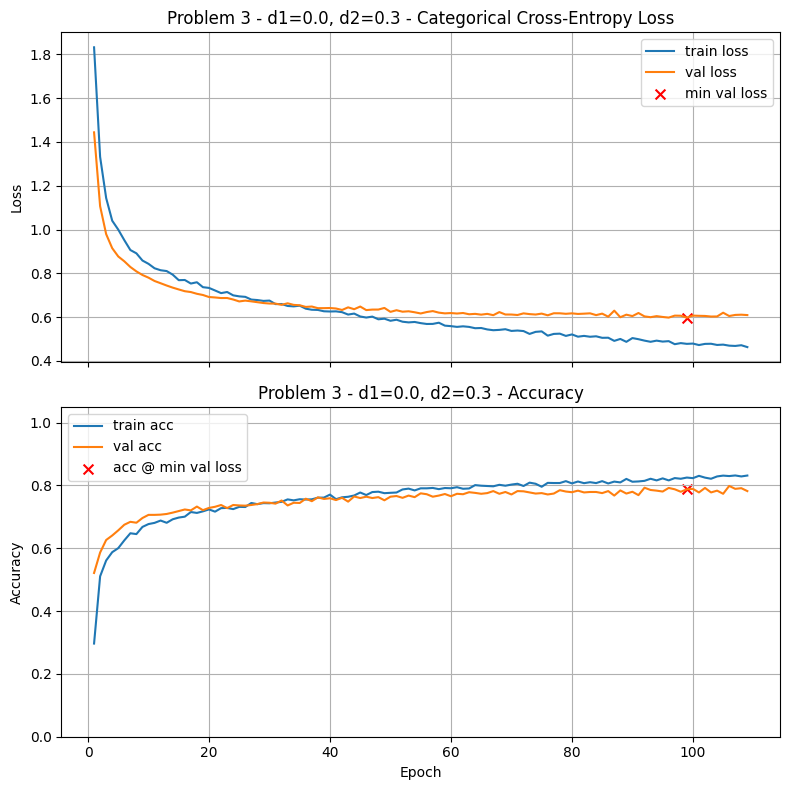

Final Training Loss:            0.4633
Final Training Accuracy:        0.8317
Final Validation Loss:          0.6096
Final Validation Accuracy:      0.7821
Minimum Validation Loss:        0.5979 (Epoch 99)
Validation Accuracy @ Min Loss: 0.7879

Test Loss: 0.6236
Test Accuracy: 0.7729

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:19
Best epoch (min val_loss): 98
Validation accuracy at best epoch: 0.7879

===== Dropout (layer64=0.0, layer32=0.4) =====

Problem 3 - d1=0.0, d2=0.4



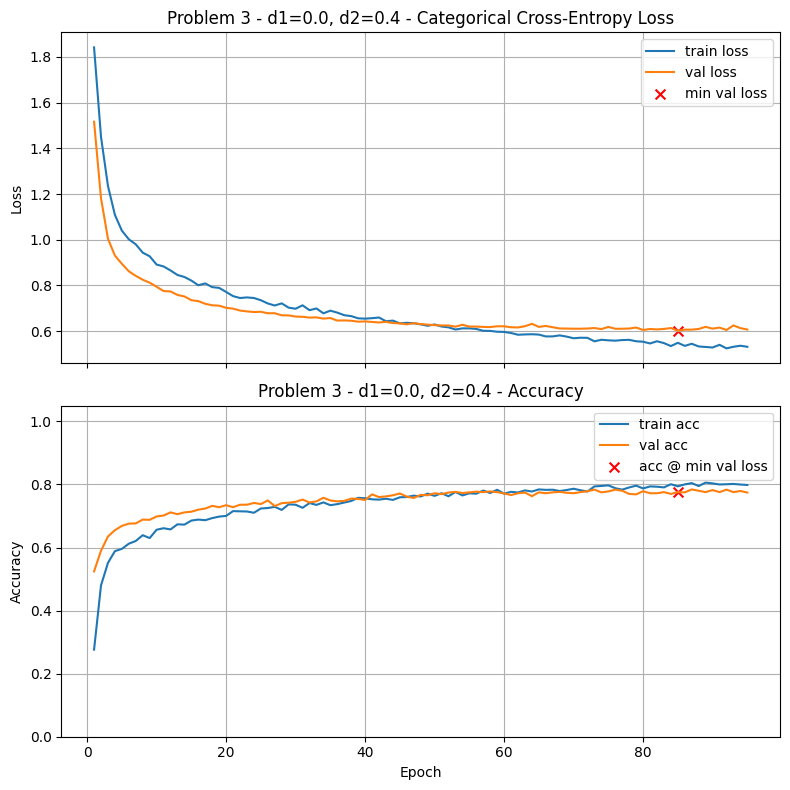

Final Training Loss:            0.5318
Final Training Accuracy:        0.7983
Final Validation Loss:          0.6074
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.6022 (Epoch 85)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.6365
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.022857

Execution Time: 00:00:16
Best epoch (min val_loss): 84
Validation accuracy at best epoch: 0.7757

===== Dropout (layer64=0.0, layer32=0.5) =====

Problem 3 - d1=0.0, d2=0.5



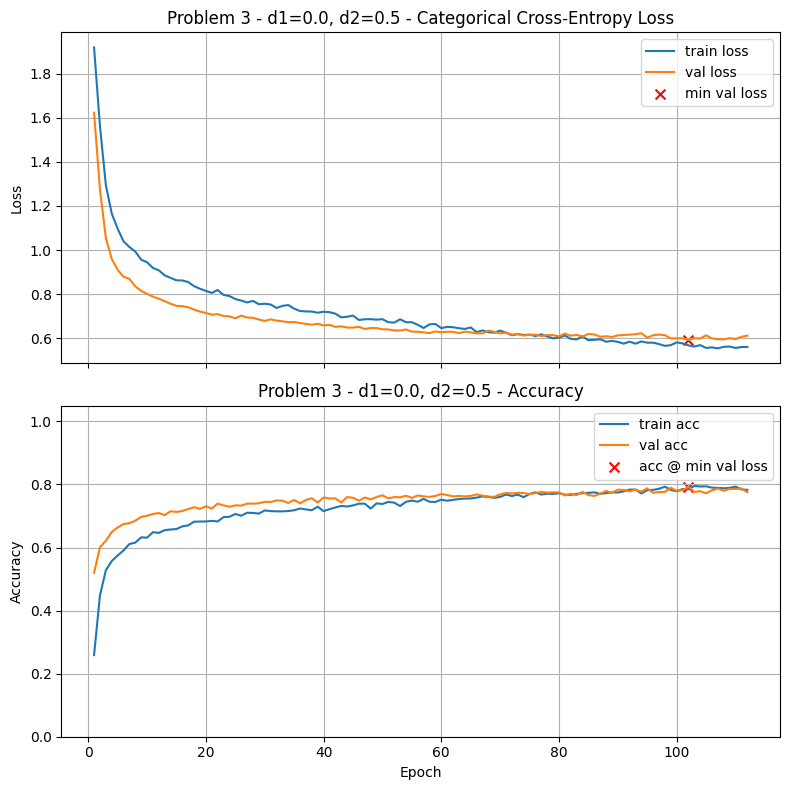

Final Training Loss:            0.5603
Final Training Accuracy:        0.7829
Final Validation Loss:          0.6118
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5920 (Epoch 102)
Validation Accuracy @ Min Loss: 0.7929

Test Loss: 0.6362
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.030000

Execution Time: 00:00:20
Best epoch (min val_loss): 101
Validation accuracy at best epoch: 0.7929

===== Dropout (layer64=0.1, layer32=0.3) =====

Problem 3 - d1=0.1, d2=0.3



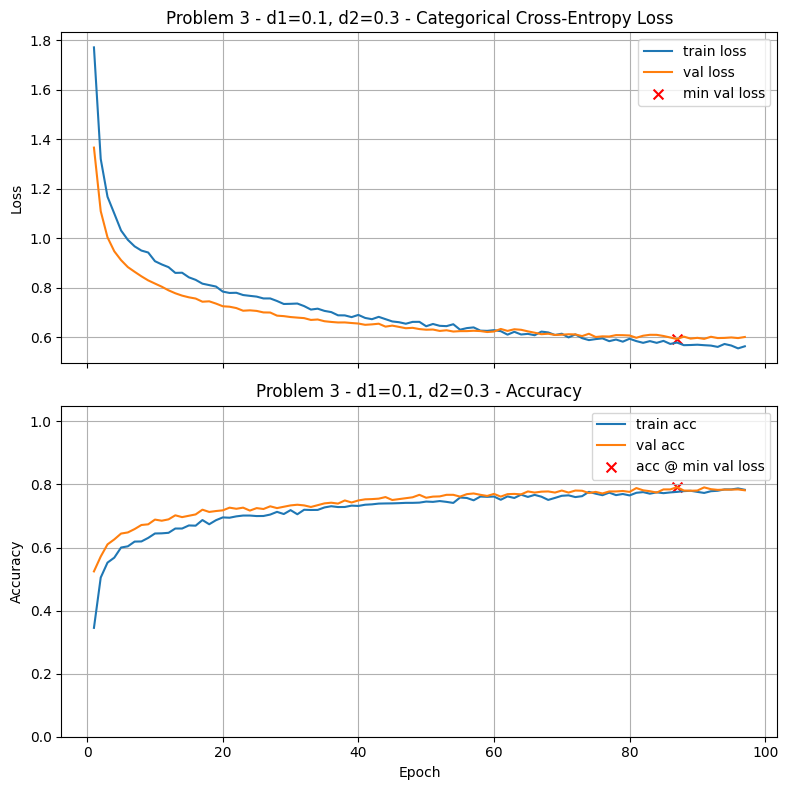

Final Training Loss:            0.5643
Final Training Accuracy:        0.7831
Final Validation Loss:          0.6018
Final Validation Accuracy:      0.7814
Minimum Validation Loss:        0.5937 (Epoch 87)
Validation Accuracy @ Min Loss: 0.7914

Test Loss: 0.6186
Test Accuracy: 0.7721

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:18
Best epoch (min val_loss): 86
Validation accuracy at best epoch: 0.7914

===== Dropout (layer64=0.1, layer32=0.4) =====

Problem 3 - d1=0.1, d2=0.4



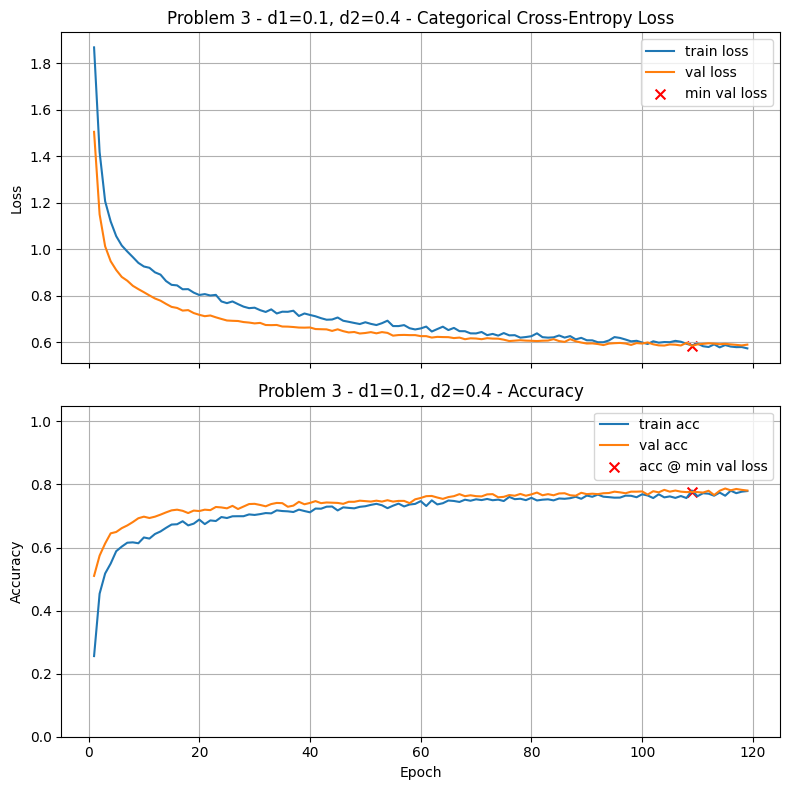

Final Training Loss:            0.5744
Final Training Accuracy:        0.7790
Final Validation Loss:          0.5906
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.5854 (Epoch 109)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6322
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.022857

Execution Time: 00:00:21
Best epoch (min val_loss): 108
Validation accuracy at best epoch: 0.7764

===== Dropout (layer64=0.1, layer32=0.5) =====

Problem 3 - d1=0.1, d2=0.5



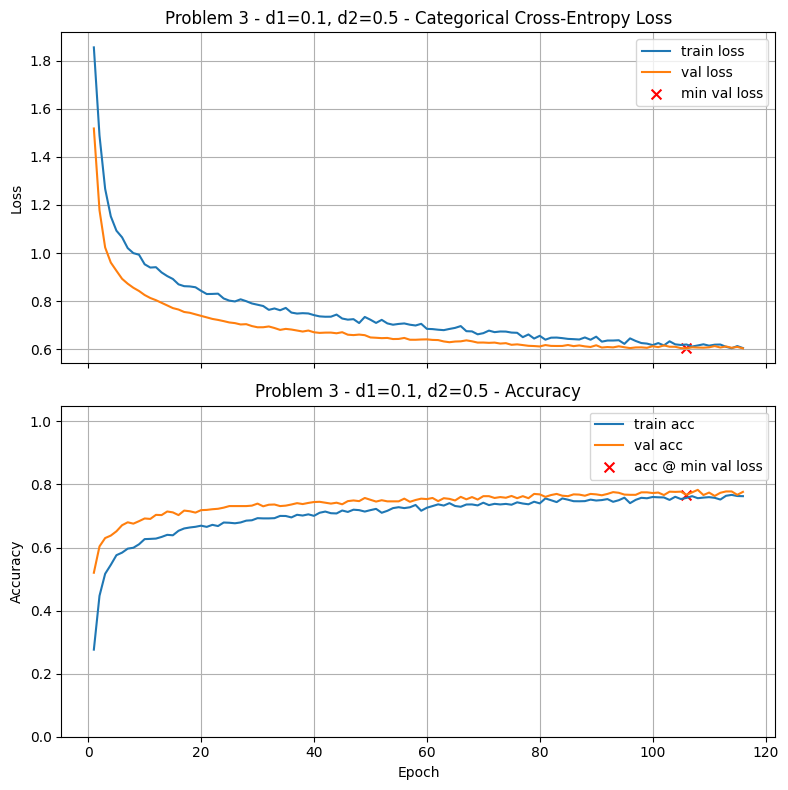

Final Training Loss:            0.6045
Final Training Accuracy:        0.7629
Final Validation Loss:          0.6034
Final Validation Accuracy:      0.7764
Minimum Validation Loss:        0.6032 (Epoch 106)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6554
Test Accuracy: 0.7464

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:21
Best epoch (min val_loss): 105
Validation accuracy at best epoch: 0.7671

===== Dropout (layer64=0.2, layer32=0.3) =====

Problem 3 - d1=0.2, d2=0.3



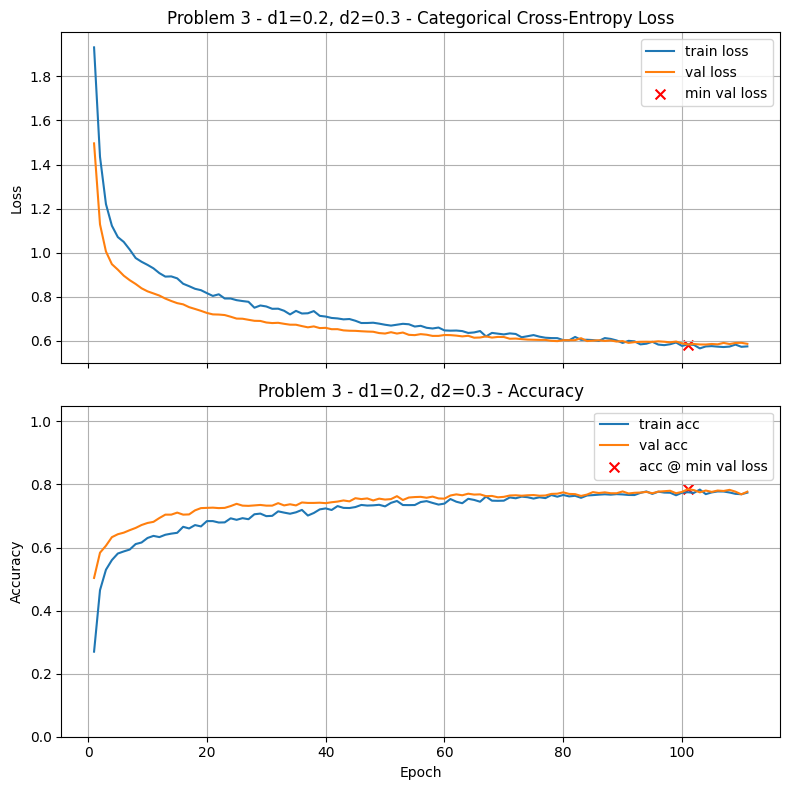

Final Training Loss:            0.5750
Final Training Accuracy:        0.7740
Final Validation Loss:          0.5866
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.5834 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7850

Test Loss: 0.6263
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:20
Best epoch (min val_loss): 100
Validation accuracy at best epoch: 0.7850

===== Dropout (layer64=0.2, layer32=0.4) =====

Problem 3 - d1=0.2, d2=0.4



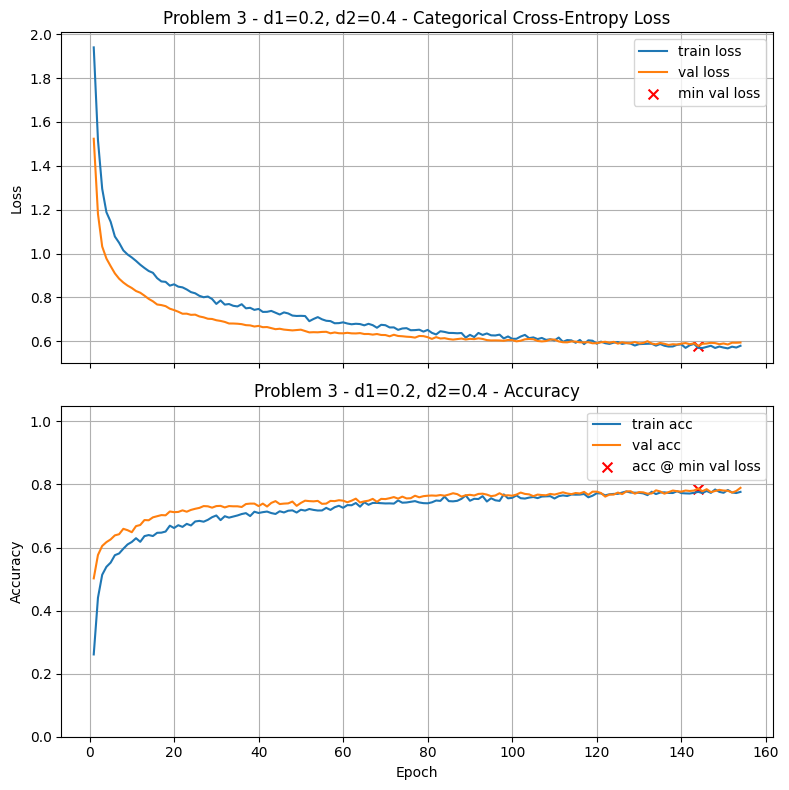

Final Training Loss:            0.5795
Final Training Accuracy:        0.7764
Final Validation Loss:          0.5945
Final Validation Accuracy:      0.7893
Minimum Validation Loss:        0.5791 (Epoch 144)
Validation Accuracy @ Min Loss: 0.7871

Test Loss: 0.6325
Test Accuracy: 0.7721

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:27
Best epoch (min val_loss): 143
Validation accuracy at best epoch: 0.7871

===== Dropout (layer64=0.2, layer32=0.5) =====

Problem 3 - d1=0.2, d2=0.5



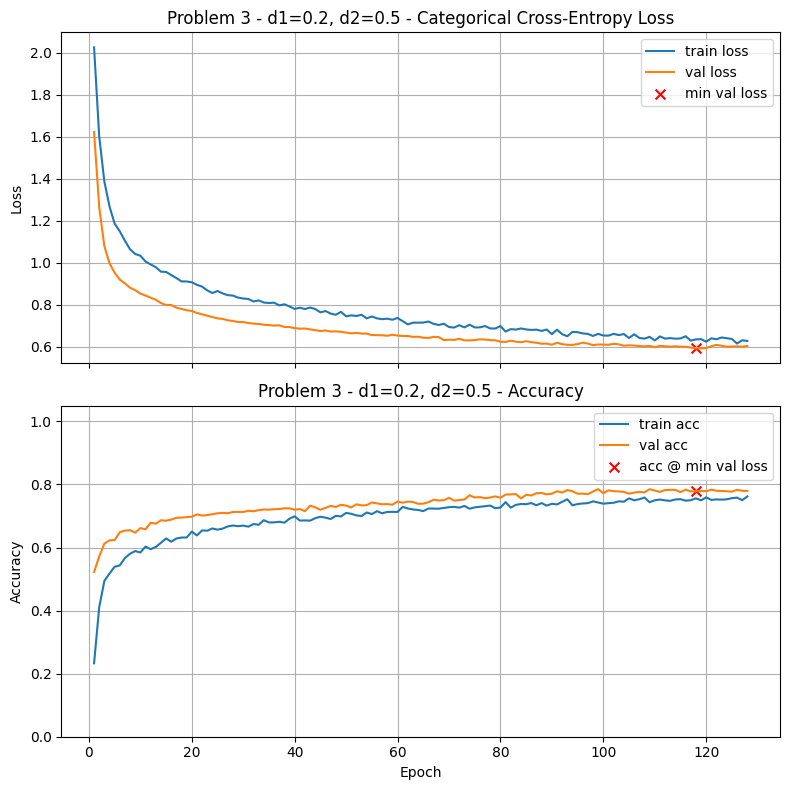

Final Training Loss:            0.6269
Final Training Accuracy:        0.7619
Final Validation Loss:          0.6028
Final Validation Accuracy:      0.7793
Minimum Validation Loss:        0.5913 (Epoch 118)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.6305
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:00:23
Best epoch (min val_loss): 117
Validation accuracy at best epoch: 0.7786

Best dropout config: (d1, d2) = (0.0, 0.5)
Best validation accuracy: 0.7929


In [31]:
# Your code here. Add as many cells as you need. 

# Use best settings from Problems 1–2
best_activation = "relu"   # because a1a = 0
best_lr = a2a              # or use best_lr if you stored it; a2a is safest

# Dropout ranges (per instructions)
drop1_vals = [0.0, 0.1, 0.2]        # earlier layer (64)
drop2_vals = [0.3, 0.4, 0.5]        # later layer (32)

results_val_acc = {}   # key = (drop1, drop2) -> best val acc
results_epoch = {}     # key = (drop1, drop2) -> best epoch
histories = {}         # store histories if you want

n_classes = len(np.unique(y_train))
n_inputs = X_train.shape[1]

for d1 in drop1_vals:
    for d2 in drop2_vals:
        print(f"\n===== Dropout (layer64={d1}, layer32={d2}) =====")

        # Set learning rate used by build_model (same pattern as Problem 2)
        LEARNING_RATE = best_lr

        # Keep architecture fixed: input -> 64 -> 32 -> output
        layer_list = [
            (64, best_activation, 0.0,   d1),   # earlier layer: smaller dropout
            (32, best_activation, 0.001, d2)    # later layer: larger dropout
        ]

        model = build_model(n_inputs, layer_list, n_classes)

        history = train_and_test(
            model,
            title=f"Problem 3 - d1={d1}, d2={d2}",
            return_history=True,
            verbose=0
        )

        histories[(d1, d2)] = history

        # Select epoch of minimum validation loss
        best_epoch = int(np.argmin(history.history["val_loss"]))
        best_val_acc = float(history.history["val_accuracy"][best_epoch])

        results_epoch[(d1, d2)] = best_epoch
        results_val_acc[(d1, d2)] = best_val_acc

        print(f"Best epoch (min val_loss): {best_epoch}")
        print(f"Validation accuracy at best epoch: {best_val_acc:.4f}")

# Find best dropout configuration
best_dropout = max(results_val_acc, key=results_val_acc.get)
best_d1, best_d2 = best_dropout
best_val = results_val_acc[best_dropout]

print("\n==============================")
print("Best dropout config: (d1, d2) =", best_dropout)
print(f"Best validation accuracy: {best_val:.4f}")
print("==============================")


In [33]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.0, 0.0)             # Replace (0.0,0.0) with your answer

In [34]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.0, 0.0)


In [35]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = best_val             # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7929


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



===== L2 config (λ64=0.0001, λ32=0.0001) =====

Problem 4 - L2=(0.0001,0.0001)



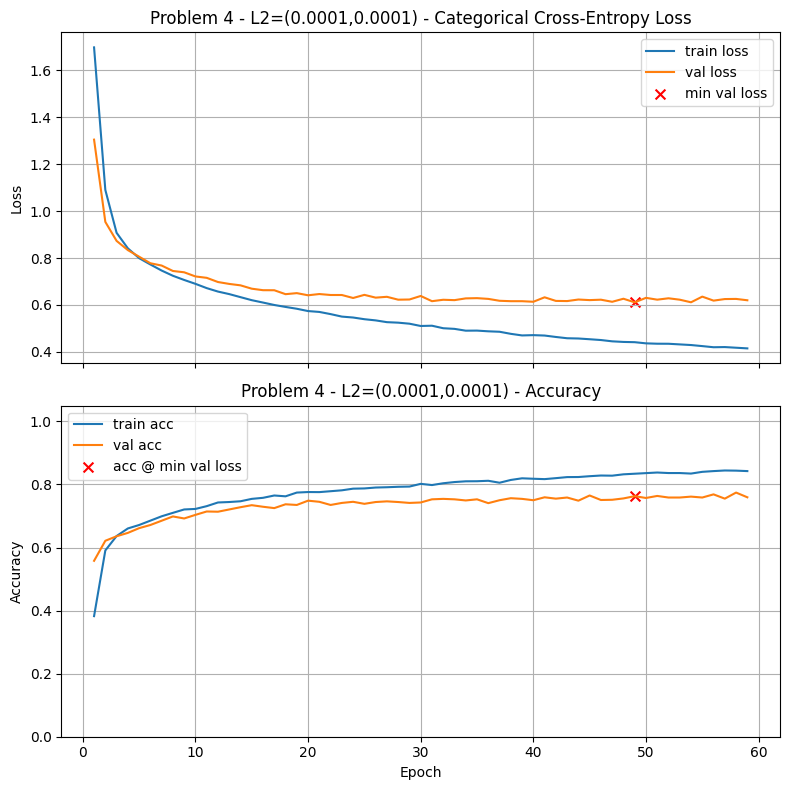

Final Training Loss:            0.4150
Final Training Accuracy:        0.8424
Final Validation Loss:          0.6201
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.6113 (Epoch 49)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6208
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:12
Best epoch (min val_loss): 48
Validation accuracy at best epoch: 0.7629

===== L2 config (λ64=0.001, λ32=0.001) =====

Problem 4 - L2=(0.001,0.001)



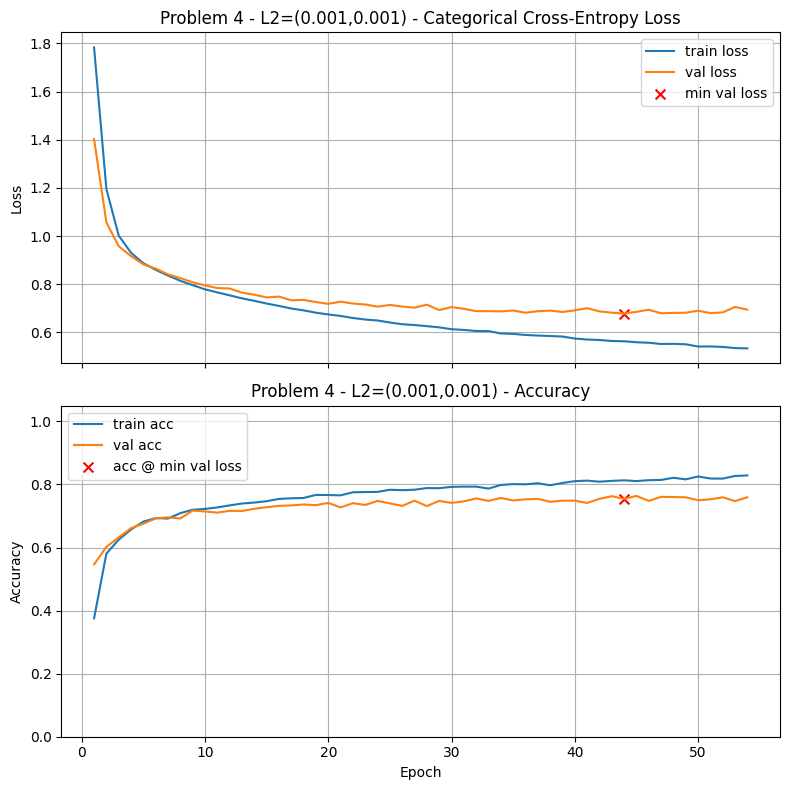

Final Training Loss:            0.5331
Final Training Accuracy:        0.8286
Final Validation Loss:          0.6941
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.6780 (Epoch 44)
Validation Accuracy @ Min Loss: 0.7543

Test Loss: 0.6912
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:10
Best epoch (min val_loss): 43
Validation accuracy at best epoch: 0.7543

===== L2 config (λ64=0.01, λ32=0.01) =====

Problem 4 - L2=(0.01,0.01)



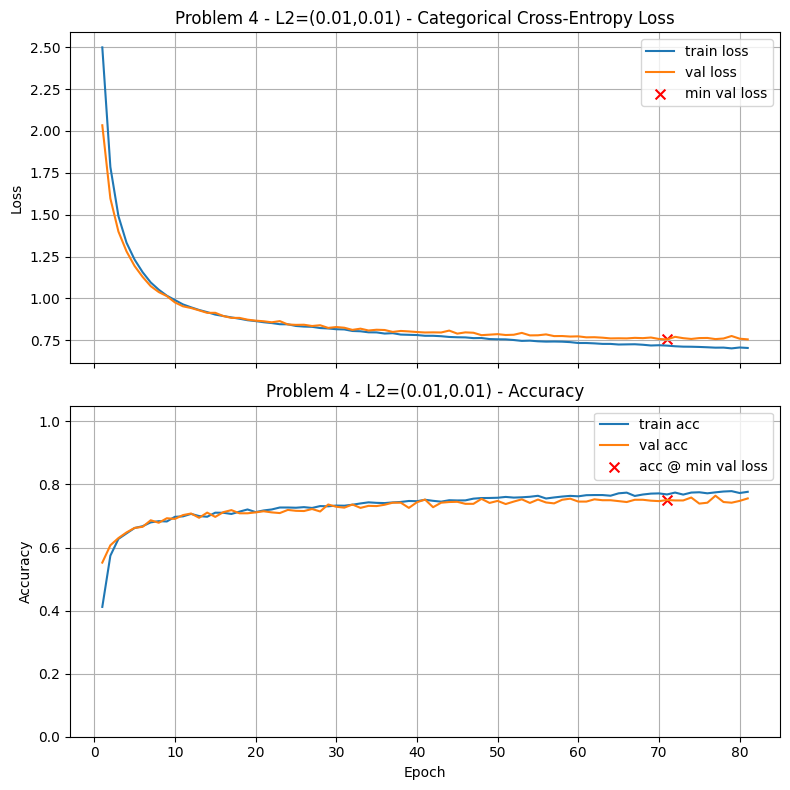

Final Training Loss:            0.7040
Final Training Accuracy:        0.7767
Final Validation Loss:          0.7553
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.7550 (Epoch 71)
Validation Accuracy @ Min Loss: 0.7507

Test Loss: 0.7708
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:15
Best epoch (min val_loss): 70
Validation accuracy at best epoch: 0.7507

===== L2 config (λ64=0.0001, λ32=0.001) =====

Problem 4 - L2=(0.0001,0.001)



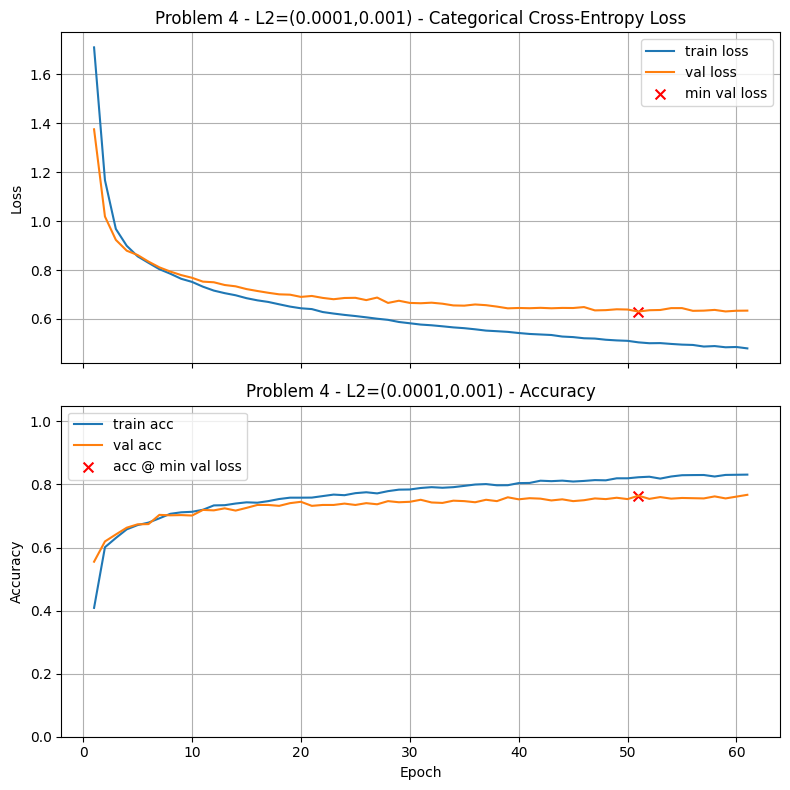

Final Training Loss:            0.4800
Final Training Accuracy:        0.8312
Final Validation Loss:          0.6341
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.6304 (Epoch 51)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6533
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:11
Best epoch (min val_loss): 50
Validation accuracy at best epoch: 0.7643

Best L2 configuration: (0.0001, 0.001)
Best validation accuracy: 0.7643


In [37]:
# Your code here. Add as many cells as you need. 

# Best settings from previous problems
best_activation = "relu"   # a1a = 0
best_lr = a2a              # learning rate from Problem Two

# L2 configurations to test (at least four)
l2_configs = [
    (1e-4, 1e-4),
    (1e-3, 1e-3),
    (1e-2, 1e-2),
    (1e-4, 1e-3)   # mixed example
]

results_val_acc = {}
results_epoch = {}
histories = {}

n_classes = len(np.unique(y_train))
n_inputs = X_train.shape[1]

for l2_1, l2_2 in l2_configs:
    print(f"\n===== L2 config (λ64={l2_1}, λ32={l2_2}) =====")

    # Set learning rate used by build_model
    LEARNING_RATE = best_lr

    # NO DROPOUT in Problem Four
    layer_list = [
        (64, best_activation, l2_1, 0.0),
        (32, best_activation, l2_2, 0.0)
    ]

    model = build_model(n_inputs, layer_list, n_classes)

    history = train_and_test(
        model,
        title=f"Problem 4 - L2=({l2_1},{l2_2})",
        return_history=True,
        verbose=0
    )

    histories[(l2_1, l2_2)] = history

    # Early stopping: epoch of minimum validation loss
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])

    results_epoch[(l2_1, l2_2)] = best_epoch
    results_val_acc[(l2_1, l2_2)] = best_val_acc

    print(f"Best epoch (min val_loss): {best_epoch}")
    print(f"Validation accuracy at best epoch: {best_val_acc:.4f}")

# Identify best L2 configuration
best_l2 = max(results_val_acc, key=results_val_acc.get)
best_l2_1, best_l2_2 = best_l2
best_val = results_val_acc[best_l2]

print("\n==============================")
print("Best L2 configuration:", best_l2)
print(f"Best validation accuracy: {best_val:.4f}")
print("==============================")


In [38]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (best_l2_1, best_l2_2)             # Replace (0.0,0.0) with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.001)


In [40]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = best_val             # Replace 0.0 with your answer

In [41]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7643


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




===== Dropout (0.0, 0.0) | L2 (0.0001, 0.0001) =====

P5 d=(0.0,0.0) l2=0.0001



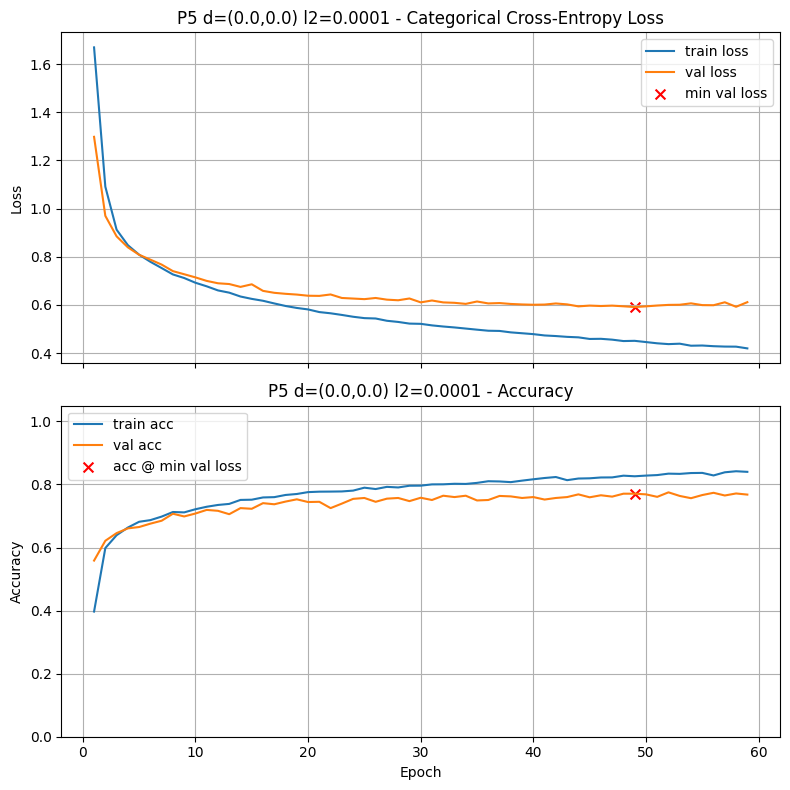

Final Training Loss:            0.4193
Final Training Accuracy:        0.8400
Final Validation Loss:          0.6112
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5910 (Epoch 49)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.6060
Test Accuracy: 0.7721

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:11
Best epoch (min val_loss): 48
Validation accuracy: 0.7707

===== Dropout (0.0, 0.0) | L2 (0.001, 0.001) =====

P5 d=(0.0,0.0) l2=0.001



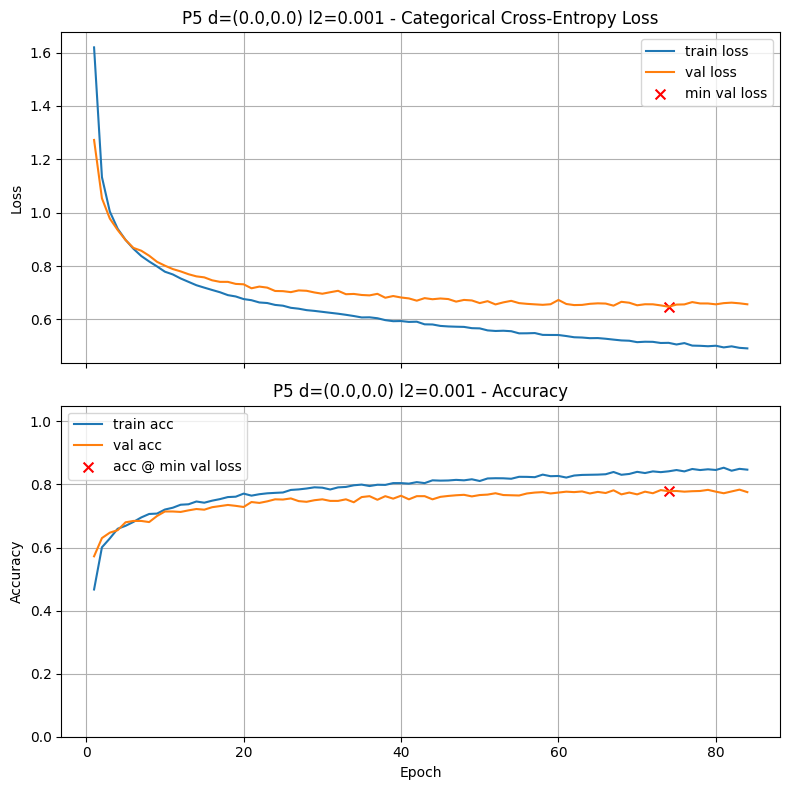

Final Training Loss:            0.4914
Final Training Accuracy:        0.8469
Final Validation Loss:          0.6566
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.6476 (Epoch 74)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.6786
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:15
Best epoch (min val_loss): 73
Validation accuracy: 0.7786

===== Dropout (0.0, 0.0) | L2 (0.01, 0.01) =====

P5 d=(0.0,0.0) l2=0.01



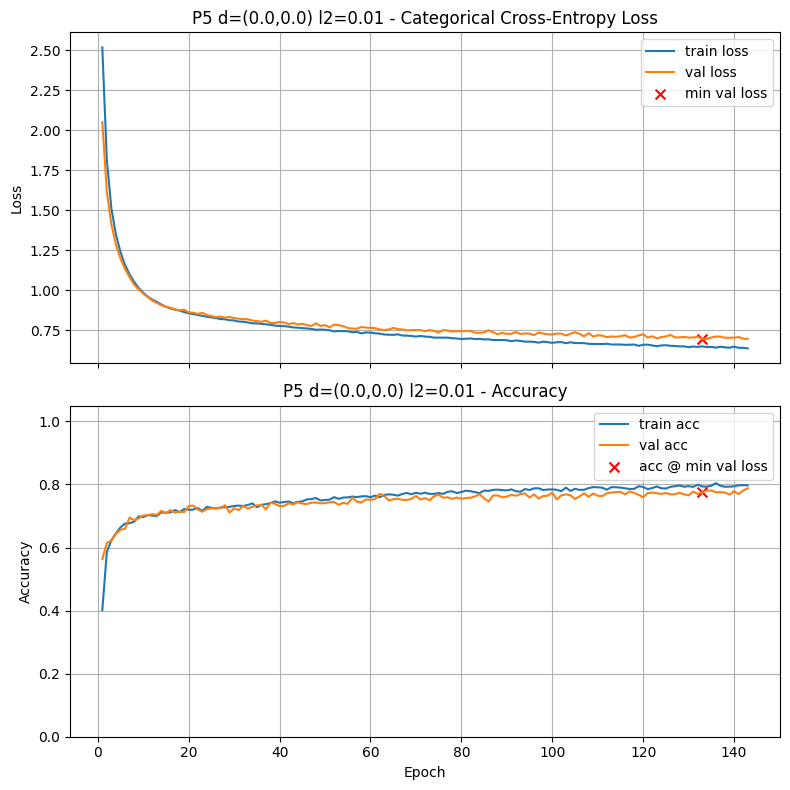

Final Training Loss:            0.6370
Final Training Accuracy:        0.7971
Final Validation Loss:          0.6961
Final Validation Accuracy:      0.7879
Minimum Validation Loss:        0.6953 (Epoch 133)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.7304
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:24
Best epoch (min val_loss): 132
Validation accuracy: 0.7750

===== Dropout (0.0, 0.0) | L2 (0.0001, 0.0001) =====

P5 d=(0.0,0.0) l2=0.0001



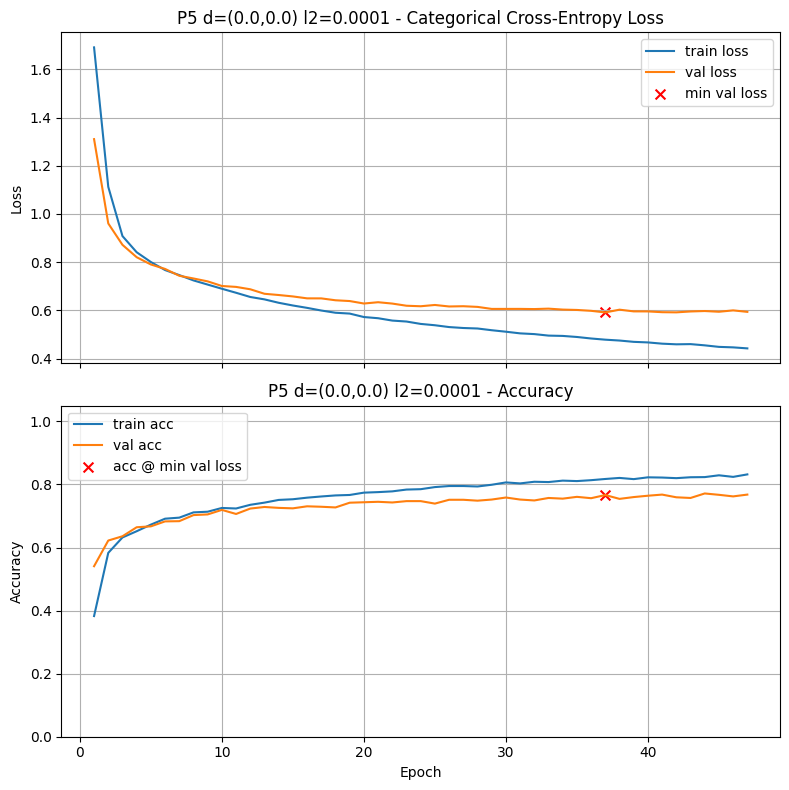

Final Training Loss:            0.4425
Final Training Accuracy:        0.8319
Final Validation Loss:          0.5940
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5916 (Epoch 37)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6098
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:10
Best epoch (min val_loss): 36
Validation accuracy: 0.7664

===== Dropout (0.0, 0.0) | L2 (0.001, 0.001) =====

P5 d=(0.0,0.0) l2=0.001



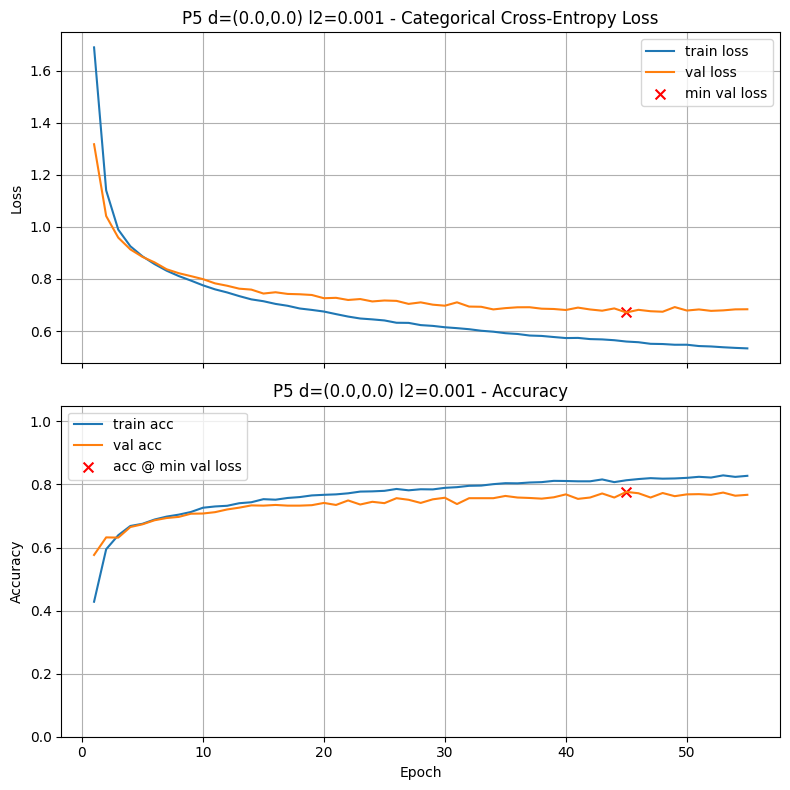

Final Training Loss:            0.5332
Final Training Accuracy:        0.8274
Final Validation Loss:          0.6836
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.6712 (Epoch 45)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6819
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:11
Best epoch (min val_loss): 44
Validation accuracy: 0.7764

===== Dropout (0.0, 0.0) | L2 (0.01, 0.01) =====

P5 d=(0.0,0.0) l2=0.01



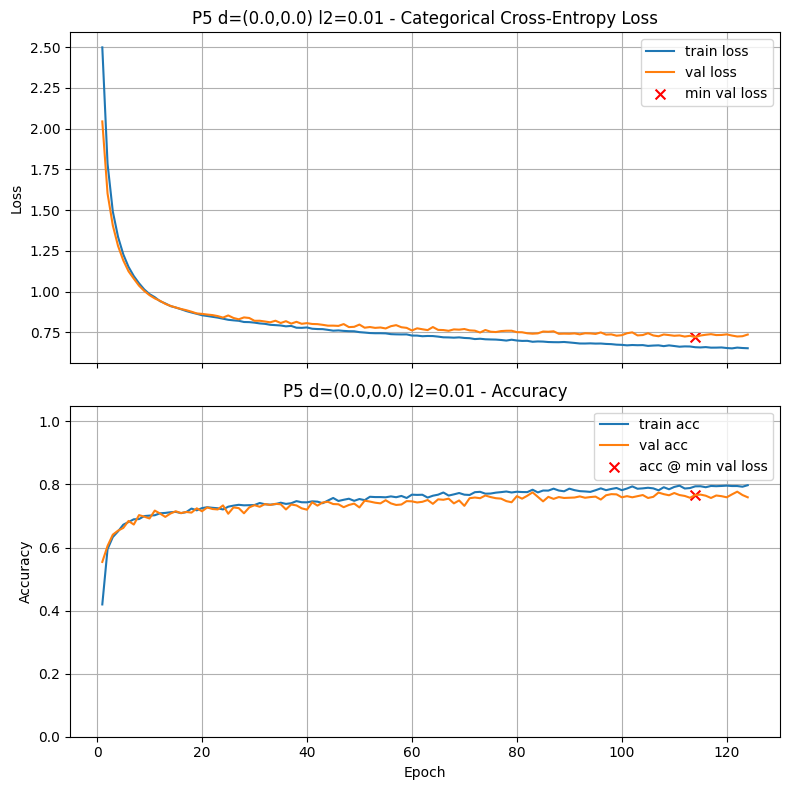

Final Training Loss:            0.6524
Final Training Accuracy:        0.7976
Final Validation Loss:          0.7364
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.7207 (Epoch 114)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.7379
Test Accuracy: 0.7479

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:22
Best epoch (min val_loss): 113
Validation accuracy: 0.7664

Best combo:
 Dropout: (0.0, 0.0)
 L2: 0.001
Best validation accuracy: 0.7764


In [42]:
# Your code here. Add as many cells as you need.

# Best settings from previous problems
best_activation = "relu"      # a1a = 0
best_lr = a2a                 # from Problem Two
best_drop1, best_drop2 = a3a  # from Problem Three

# L2 values to try
l2_vals = [1e-4, 1e-3, 1e-2]

# Dropout configs to try:
# 1) baseline dropout
# 2) slightly reduced dropout
dropout_configs = [
    (best_drop1, best_drop2),
    (max(0.0, best_drop1 - 0.1), max(0.0, best_drop2 - 0.1))
]

results_val_acc = {}
results_epoch = {}
histories = {}

n_classes = len(np.unique(y_train))
n_inputs = X_train.shape[1]

for d1, d2 in dropout_configs:
    for l2 in l2_vals:
        print(f"\n===== Dropout ({d1}, {d2}) | L2 ({l2}, {l2}) =====")

        # Learning rate picked up internally by build_model
        LEARNING_RATE = best_lr

        layer_list = [
            (64, best_activation, l2, d1),
            (32, best_activation, l2, d2)
        ]

        model = build_model(n_inputs, layer_list, n_classes)

        history = train_and_test(
            model,
            title=f"P5 d=({d1},{d2}) l2={l2}",
            return_history=True,
            verbose=0
        )

        key = (d1, d2, l2)
        histories[key] = history

        # Early stopping: epoch of minimum validation loss
        best_epoch = int(np.argmin(history.history["val_loss"]))
        best_val_acc = float(history.history["val_accuracy"][best_epoch])

        results_epoch[key] = best_epoch
        results_val_acc[key] = best_val_acc

        print(f"Best epoch (min val_loss): {best_epoch}")
        print(f"Validation accuracy: {best_val_acc:.4f}")

# Pick best overall combination
best_combo = max(results_val_acc, key=results_val_acc.get)
best_d1, best_d2, best_l2 = best_combo
best_val = results_val_acc[best_combo]

print("\n==============================")
print("Best combo:")
print(" Dropout:", (best_d1, best_d2))
print(" L2:", best_l2)
print(f"Best validation accuracy: {best_val:.4f}")
print("==============================")


In [43]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = best_val             # Replace 0.0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7764


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Problem 6 - Best Model



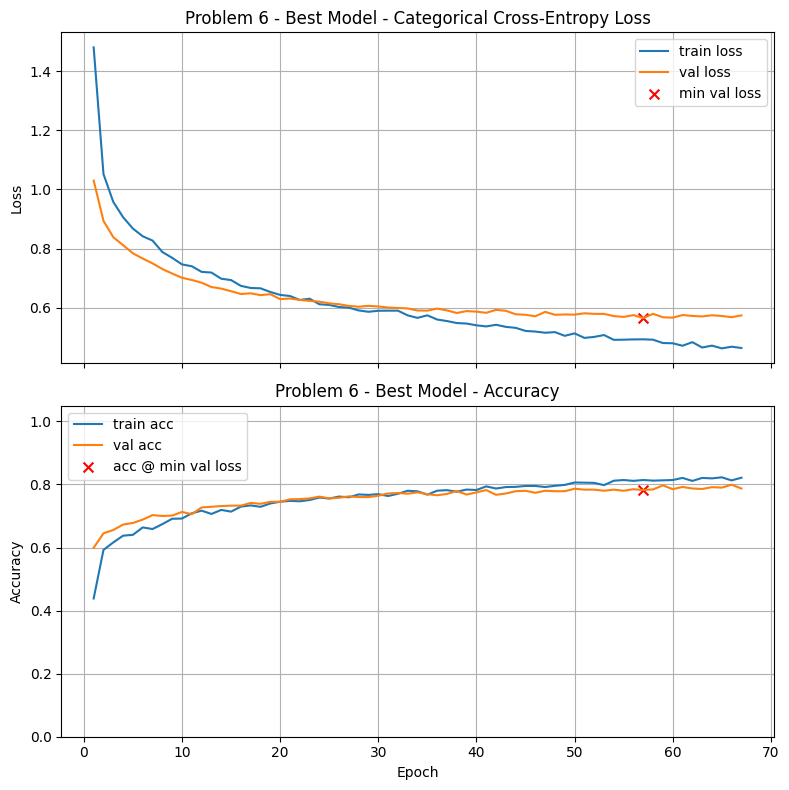

Final Training Loss:            0.4635
Final Training Accuracy:        0.8214
Final Validation Loss:          0.5738
Final Validation Accuracy:      0.7871
Minimum Validation Loss:        0.5645 (Epoch 57)
Validation Accuracy @ Min Loss: 0.7821

Test Loss: 0.5933
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:14
Best epoch: 56
Best validation accuracy: 0.7821428775787354


In [45]:
# Your code here
import numpy as np
import tensorflow as tf

# -------------------------
# Design choices (explicit)
# -------------------------
activation = "relu"
batch_size = 64

dropout_1 = 0.1
dropout_2 = 0.3

l2_1 = 1e-4
l2_2 = 1e-4

initial_lr = a2a          # best LR from Problem Two
decay_rate = 0.95         # recommended range
decay_steps = 1000        # reasonable default

# Exponential decay scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# Make scheduler visible to build_model
LEARNING_RATE = lr_schedule

# -------------------------
# Build the model
# -------------------------
n_classes = len(np.unique(y_train))
n_inputs = X_train.shape[1]

layer_list = [
    (128, activation, l2_1, dropout_1),
    (64,  activation, l2_2, dropout_2)
]

model_best = build_model(n_inputs, layer_list, n_classes)

# -------------------------
# Train with early stopping
# -------------------------
history = train_and_test(
    model_best,
    title="Problem 6 - Best Model",
    return_history=True,
    batch_size=batch_size,
    verbose=0
)

# -------------------------
# Select best epoch
# -------------------------
best_epoch = int(np.argmin(history.history["val_loss"]))
best_val_acc = float(history.history["val_accuracy"][best_epoch])

print("Best epoch:", best_epoch)
print("Best validation accuracy:", best_val_acc)


In [46]:
# Set a6 to the validation accuracy found by this best model

a6 = best_val_acc             # Replace 0.0 with your answer

In [47]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7821


### Optional: Print out your results of all experiments

In [48]:
print_results()

Problem 3 - d1=0.0, d2=0.5              	0.7929
Problem 3 - d1=0.1, d2=0.3              	0.7914
Problem 3 - d1=0.0, d2=0.3              	0.7879
Problem 3 - d1=0.2, d2=0.4              	0.7871
Problem 3 - d1=0.2, d2=0.3              	0.7850
Problem 6 - Best Model                  	0.7821
Problem 2 - lr = 0.001                  	0.7786
Problem 2 - lr = 5e-05                  	0.7786
Problem 3 - d1=0.2, d2=0.5              	0.7786
Problem 1 - activation = relu           	0.7771
Problem 3 - d1=0.1, d2=0.4              	0.7764
P5 d=(0.0,0.0) l2=0.001                 	0.7764
Problem 3 - d1=0.0, d2=0.4              	0.7757
Problem 2 - lr = 1e-05                  	0.7714
Problem 2 - lr = 0.0001                 	0.7693
Problem 2 - lr = 0.0005                 	0.7671
Problem 3 - d1=0.1, d2=0.5              	0.7671
P5 d=(0.0,0.0) l2=0.0001                	0.7664
P5 d=(0.0,0.0) l2=0.01                  	0.7664
Problem 4 - L2=(0.0001,0.001)           	0.7643
Problem 1 - activation = sigmoid        

## Reflection Questions (ungraded)

It would be a great idea to think through your answers to these questions, then give ChatGPT (or other AI tool) a PDF of your
homework, and **discuss** (not just ask) these. 

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?